### Notes on Variational Classifier

* Pennylane reference tutorial / [documentation](https://pennylane.ai/qml/demos/tutorial_variational_classifier/)
* What are **Variational Quantum Classifier**s
  * These are quantum circuits that can be trained from labeled data to classify new data samples.

### Example Case 1: Parity Function

We would like to emulate a parity function, defined as follows. We will use a variational quantum circuit to achieve this.

$$ \begin{split}f: x \in \{0,1\}^{\otimes n} \rightarrow y =
\begin{cases} 1 \text{  if uneven number of ones in } x \\ 0
\text{ otherwise} \end{cases}.\end{split}$$

The usage of the parity function in illustrates an example of encoding binary inputs to the initial state of the circuit, with _basis encoding_.

#### Imports
We start by importing the usual set of required modules, `pennaylane`, their version of `numpy` and an optimizer.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

#### Strategy

We will build a hybrid system of quantum circuit and a bit of logic on a classical system. 
* The quantum cicuit is **trainable** using parameters, which borrowing terminologies from classical machine learning, we will refer as `weights`.
* The clsssical component will be the driver as well used for calculation of loss, optimization as well pre and post processing as necessary.


In [2]:
dev = qml.device("default.qubit")

Building blocks for variations classifiers are typically referred as `layers` or `block`, which is a smaller circuit that is often repeated to build a larger network. As mentioned earlier, we call our parameters as `weights`.

* We encode our parameters in rotation
* We use entanglement between all the qubits

Let's build a `layer`. We will use four qubits for the experiment.

In [3]:
num_qubits = 4

def layer(layer_weights):
    for wire in range(num_qubits):
        qml.Rot(*layer_weights[wire], wires=wire)

    l1 = range(num_qubits)
    # list(zip(l1, [(x + 1) % 4 for x in l1]))
    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

We want to be able to feed the input $ x $ into the circuit. To that extent, we encode the bit strings into qubit states.

* Example: $x = 0111 \rightarrow |\psi \rangle = |0111 \rangle .$

We use the `BasisState` function from pennyLane for this, where `x` is provided as a list of zeros and ones, i.e `[0,1,1,1]`


In [4]:
def prepare_state(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Here we create our quantum circuit - that includes state preparation and all the layers / blocks.

In [5]:
@qml.qnode(dev)
def qcircuit(weights, x):
    prepare_state(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))


And we add a trainable `bias` as well.

In [6]:
def variational_classifier(weights, bias, x):
    return qcircuit(weights, x) + bias


#### Cost and accuracy calculation

* We use a very basic square loss of delta between the predictions and ground truth known labels to compute the **loss**. We calculate the cost from the loss over all the labels in a given run.
* Accuracy is simply a ratio of good / correct predictions vs the ground truth

In [7]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)


#### Optimizer


In [8]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

#### Training and Test Data

We use a set of known dataset with pre-computed parities for training and test data.

In [9]:
txt_train = """0 0 0 1 1
0 0 1 0 1
0 1 0 0 1
0 1 0 1 0
0 1 1 0 0
0 1 1 1 1
1 0 0 0 1
1 0 0 1 0
1 0 1 1 1
1 1 1 1 0
"""

txt_test = """0 0 0 0 0
0 0 1 1 0
1 0 1 0 0
1 1 1 0 1
1 1 0 0 0
1 1 0 1 1
"""

from io import StringIO
data_train = np.loadtxt(StringIO(txt_train))
data_test = np.loadtxt(StringIO(txt_test))

Let's take a look at the data.

In [10]:
data_train

tensor([[0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0.]], requires_grad=True)

We divide the train data into $x$ set (X) and label $y$ set (Y), and adjust the $y$ values from (0,1) to (-1, 1) basis.

In [11]:
X = np.array(data_train[:, :-1])
Y = np.array(data_train[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

In [12]:
Y[0], X[0]

(tensor(1., requires_grad=True), tensor([0., 0., 0., 1.], requires_grad=True))

#### Initial values
Prepare some randomized intial value for our parameters / `weights` and `biases`. Let's use a seed for repeatability.

In [13]:
iseed = 1001

np.random.seed(iseed)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)


Weights: [[[-0.01086446 -0.00896065 -0.00306299]
  [-0.01339934 -0.01206586 -0.00641727]
  [ 0.01307946  0.0184546   0.00829115]
  [-0.00023299 -0.00208564 -0.0091662 ]]

 [[-0.01074743 -0.00086143  0.01175839]
  [-0.01635092  0.01228194  0.01076386]
  [ 0.00394773 -0.00387701  0.00588402]
  [-0.01433299 -0.00323575  0.01252985]]]
Bias:  0.0


#### Put everything together

In [14]:
weights = weights_init
bias = bias_init
for it in range(25):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")


Iter:    1 | Cost: 1.9986389 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9877026 | Accuracy: 0.5000000
Iter:    3 | Cost: 2.2542488 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.5296414 | Accuracy: 0.5000000
Iter:    5 | Cost: 1.3118643 | Accuracy: 0.7000000
Iter:    6 | Cost: 1.1740383 | Accuracy: 0.5000000
Iter:    7 | Cost: 1.0247710 | Accuracy: 0.7000000
Iter:    8 | Cost: 0.9691195 | Accuracy: 0.6000000
Iter:    9 | Cost: 0.4363905 | Accuracy: 0.9000000
Iter:   10 | Cost: 0.1485392 | Accuracy: 1.0000000
Iter:   11 | Cost: 0.0117864 | Accuracy: 1.0000000
Iter:   12 | Cost: 0.0007699 | Accuracy: 1.0000000
Iter:   13 | Cost: 0.0080801 | Accuracy: 1.0000000
Iter:   14 | Cost: 0.0241090 | Accuracy: 1.0000000
Iter:   15 | Cost: 0.0290218 | Accuracy: 1.0000000
Iter:   16 | Cost: 0.0300582 | Accuracy: 1.0000000
Iter:   17 | Cost: 0.0120003 | Accuracy: 1.0000000
Iter:   18 | Cost: 0.0035209 | Accuracy: 1.0000000
Iter:   19 | Cost: 0.0008423 | Accuracy: 1.0000000
Iter:   20 | Cost: 0.0002969 | 

Our accuracy has reached 1.0 which means we are able to predict correctly from the given dataset.

Let's try a few unseen data points see if the circuit preforms well.

In [15]:
X_test = np.array(data_test[:, :-1])
Y_test = np.array(data_test[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0. 0. 0. 0.], y = -1.0, pred=-1.0
x = [0. 0. 1. 1.], y = -1.0, pred=-1.0
x = [1. 0. 1. 0.], y = -1.0, pred=-1.0
x = [1. 1. 1. 0.], y = 1.0, pred=1.0
x = [1. 1. 0. 0.], y = -1.0, pred=-1.0
x = [1. 1. 0. 1.], y = 1.0, pred=1.0
Accuracy on unseen data: 1.0


#### Conclusion
We have built a simple quantum circuit and in combination with a classical component, we have shown that our variational circuit has learned to emulate a parity functyion successfully.

### Example Case 2: Classification with Iris Dataset


The Iris data consists of 3 different types of irises' petal and sepal length, in `numpy.ndarray`. We plot using two features to get a general idea about the data.

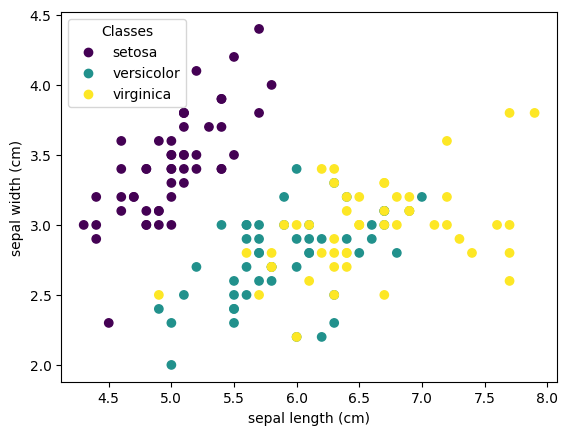

In [16]:
from sklearn import datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris()

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="upper left", title="Classes"
)

In our parity function example we were able to use a simple basis state encoding. However, the Iris dataset conists of vectors of real values. We will take a real valued vector and transform that into angles. or simplicity we use only positive subspace.

In [17]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

We will first verify that our encoding works.

In [18]:
x1 = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
x2 = np.array([0.57735027, 0.57735027, 0.0, 0.57735027], requires_grad=False)

@qml.qnode(dev)
def test(angles):
    state_preparation(angles)
    return qml.state()

for x in [x1, x2]:
    ang = get_angles(x)
    state = test(ang)
    print("x               : ", np.round(x, 6))
    print("angles          : ", np.round(ang, 6))
    print("amplitude vector: ", np.round(np.real(state), 6))
    print()


x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]

x               :  [0.57735 0.57735 0.      0.57735]
angles          :  [ 1.230959 -1.570795  1.570795 -0.785398  0.785398]
amplitude vector:  [5.7735e-01 5.7735e-01 1.0000e-06 5.7735e-01]



The above shows the angles were correct for the desired state(s). Let's define `layer` and `cost` functions. This time we use a 2 qubit circuit.

In [19]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

To match the state vector of our quantum circuit, we will pre-process the Iris data with an added pair of "latent dimensions". We need to normalize the vectors and generate angles using the function defined previously. The addition of the latent vector elements heps us retain information that will otherwise be lost with normalization.


In [20]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]


First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


Here we plot the data in various forms, the original data, normalized version of the same and the angular form to see how the cluster vs separation is seen for the variants.

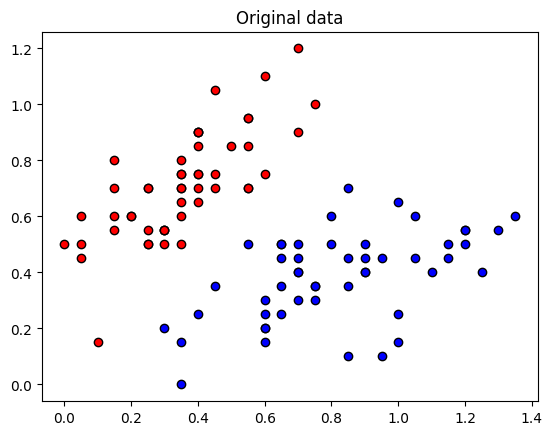

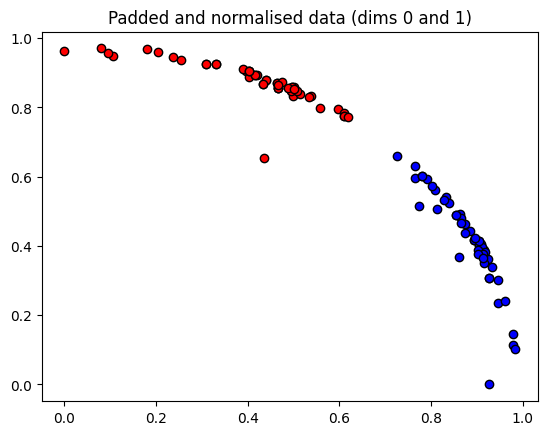

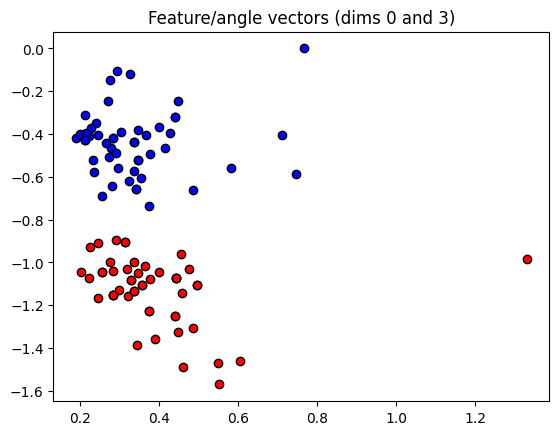

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature/angle vectors (dims {dim1} and {dim2})")
plt.show()


We break the dataset into training, validation and test set. 

In [22]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Initial values are set here. We start with random weights.

In [23]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)


Next - we take an optimzer and iterate where the weights/parameters get updated at each step/iteration. This is the core of how our classifier is _learning_.

In [25]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )


Iter:     2 | Cost: 1.6023766 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2627147 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.0292513 | Acc train: 0.4666667 | Acc validation: 0.5600000
Iter:     8 | Cost: 0.9678474 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    10 | Cost: 0.9688918 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9729272 | Acc train: 0.5466667 | Acc validation: 0.4800000
Iter:    14 | Cost: 0.9252177 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    16 | Cost: 0.8713669 | Acc train: 0.6933333 | Acc validation: 0.6800000
Iter:    18 | Cost: 0.8485919 | Acc train: 0.8000000 | Acc validation: 0.8800000
Iter:    20 | Cost: 0.8064362 | Acc train: 0.8666667 | Acc validation: 0.9600000
Iter:    22 | Cost: 0.7531130 | Acc train: 0.9066667 | Acc validation: 0.9200000
Iter:    24 | Cost: 0.7016197 | Acc train: 0.9200000 | Acc validation: 0.9600000
Iter:    26 | Cost: 0.632765

We plot the continuous output of the variational classifier for the first two dimensions of the Iris data set. We find that our variational classifier has learnt a separating line between the two classes, which shows our solution generalizes to new / unseen data.

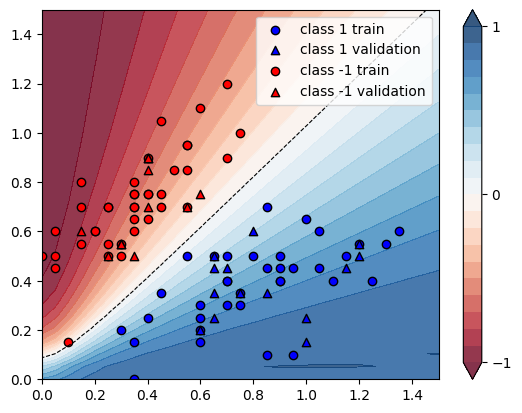

In [26]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()
